In [1]:
!pip install spotipy pandas numpy matplotlib missingno scipy seaborn

In [2]:
# Importer les bibliothèques nécessaires
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import json
import csv
import missingno as msno
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Data Acquisition

## Acquisition from API

In [3]:
# Configurer les informations d'authentification
client_id = '94b56089f9144cc9bd0ab9a7d6bd238d'
client_secret = '8715a48fa8c14ce7b54b88659d00e214'
client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [4]:
# Récupérer les données de la playlist Top 2022 de Spotify
playlist = sp.playlist('spotify:playlist:37i9dQZF1DX18jTM2l2fJY')
audio_features = sp.audio_features([item['track']['id'] for item in playlist['tracks']['items']])

### dataset modeling

In [5]:
data = [];

for index, item in enumerate(playlist['tracks']['items']):
    # playlist details
    track = {};
    track['rank'] = index
    track['playlist_name'] = playlist['name']
    track['playlist_uri'] = playlist['uri']
    track['playlist_image'] = playlist['images'][0]['url']
    track['playlist_snapshot_id'] = playlist['snapshot_id']
    track['playlist_tracks_url'] = playlist['tracks']['href']
    track['playlist_tracks_total'] = playlist['tracks']['total']
    
    #tracks items details
    track['artist_name'] = item['track']['artists'][0]['name']
    track['album_name'] = item['track']['album']['name']
    
    track['track_name'] = item['track']['name']
    track['track_uri'] = item['track']['id']
    track['track_added_at'] = item['added_at']
    track['track_preview_url'] = item['track']['preview_url']
    track['track_popularity'] = item['track']['popularity']
         
    # audio features
    features = [features for features in audio_features if features['id'] == item['track']['id']]
    features = features[0]
    
    track['danceability'] = features['danceability']
    track['energy'] = features['energy']
    track['key'] = features['key']
    track['loudness'] = features['loudness']
    track['mode'] = features['mode']
    track['speechiness'] = features['speechiness']
    track['acousticness'] = features['acousticness']
    track['instrumentalness'] = features['instrumentalness']
    track['liveness'] = features['liveness']
    track['valence'] = features['valence']
    track['tempo'] = features['tempo']
    track['duration_ms'] = features['duration_ms']
    track['time_signature'] = features['time_signature']
    data.append(track)

## Acquisition from a file

In [6]:
with open('data/spotify_top_2022.csv', 'w', newline='') as output_file:
    dict_writer = csv.DictWriter(output_file, data[0].keys())
    dict_writer.writeheader()
    dict_writer.writerows(data)

In [7]:
raw_df = pd.read_csv('data/spotify_top_2022.csv');

# Data Exploration

In [8]:
print(raw_df.describe());
print(raw_df.info());

           rank  playlist_tracks_total  track_popularity  danceability  \
count  50.00000                   50.0          50.00000     50.000000   
mean   24.50000                   50.0          85.70000      0.688460   
std    14.57738                    0.0           3.52397      0.134596   
min     0.00000                   50.0          80.00000      0.380000   
25%    12.25000                   50.0          83.00000      0.601750   
50%    24.50000                   50.0          85.00000      0.699500   
75%    36.75000                   50.0          88.00000      0.799750   
max    49.00000                   50.0          93.00000      0.911000   

          energy        key  loudness       mode  speechiness  acousticness  \
count  50.000000  50.000000  50.00000  50.000000    50.000000     50.000000   
mean    0.672780   5.380000  -5.78836   0.480000     0.069120      0.236653   
std     0.128748   3.697158   1.90153   0.504672     0.052539      0.245587   
min     0.317000 

# Data Cleaning & Shaping

## parsing of text
Removing some unnecessary columns from the data frame to make the data set easier to parse and work with

In [9]:
df = raw_df[['rank','track_name', 'track_uri', 'track_added_at', 'track_popularity', 'danceability', 'energy', 'key', 'loudness',
    'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms',
    'time_signature', 'artist_name', 'album_name']]

## Check for any missing values in the data set

<AxesSubplot:>

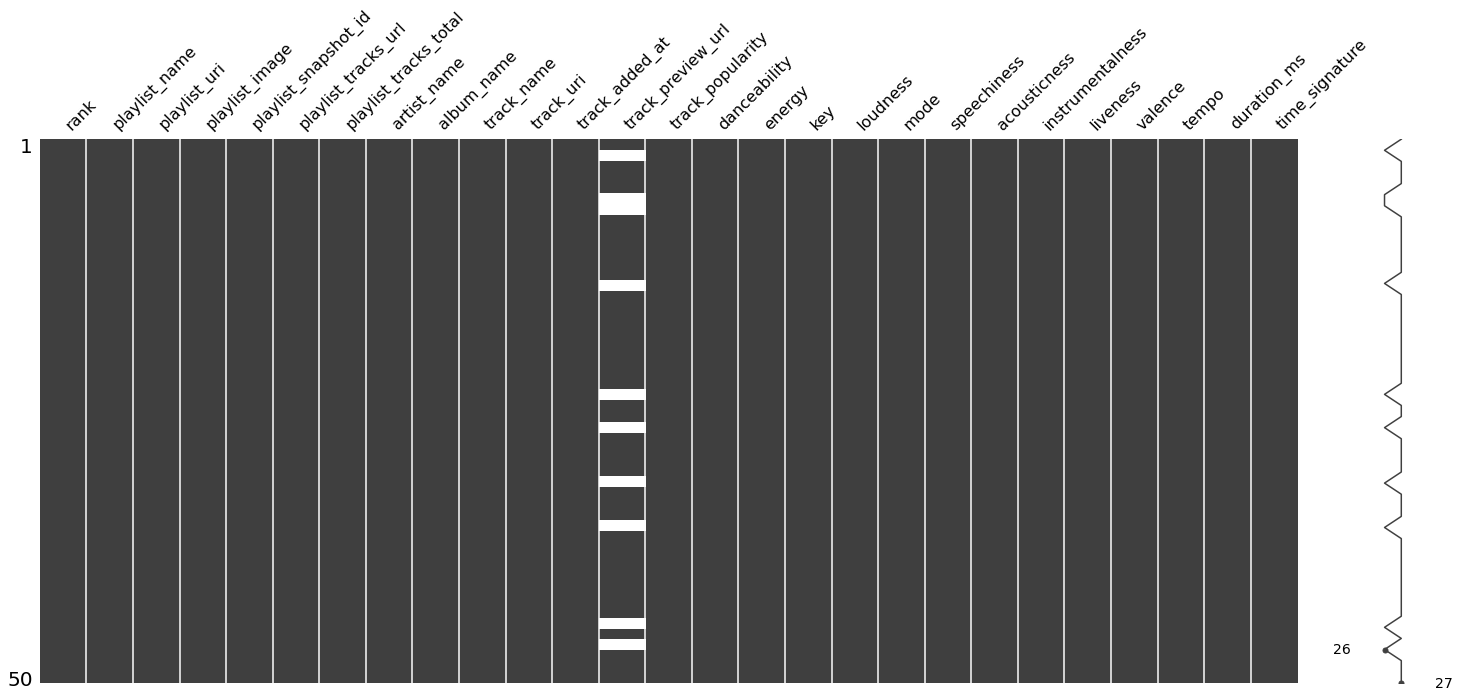

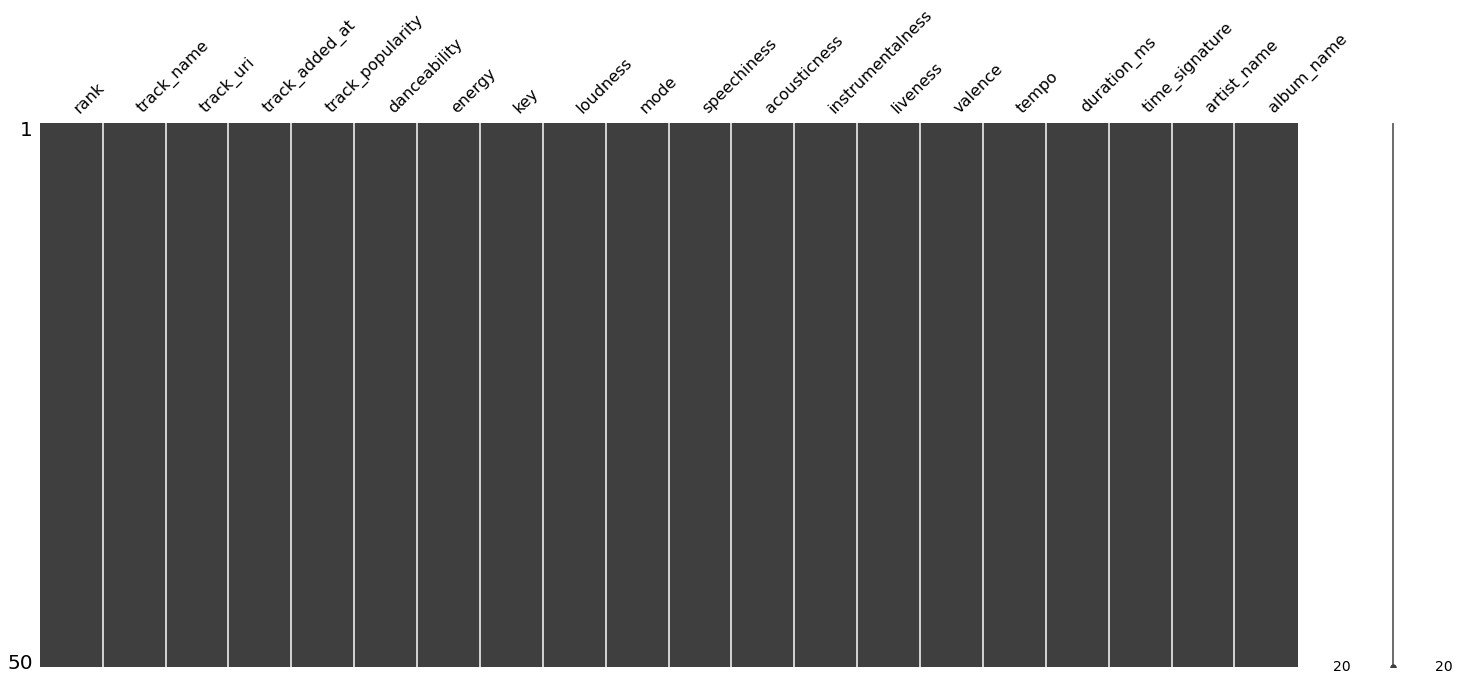

In [10]:
msno.matrix(raw_df)
msno.matrix(df)

This is a pretty small and clean data set, and there's no missing values out of the 100 tracks in this playlist.


## Normalization/standardization of feature values

In [11]:
# convert milliseconds to seconds
df['duration_ms'].mul(1000)

# rename column from 'duration_ms' to just 'duration'
df = df.rename({'duration_ms': 'duration'}, axis=1)

In [12]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   rank              50 non-null     int64  
 1   track_name        50 non-null     object 
 2   track_uri         50 non-null     object 
 3   track_added_at    50 non-null     object 
 4   track_popularity  50 non-null     int64  
 5   danceability      50 non-null     float64
 6   energy            50 non-null     float64
 7   key               50 non-null     int64  
 8   loudness          50 non-null     float64
 9   mode              50 non-null     int64  
 10  speechiness       50 non-null     float64
 11  acousticness      50 non-null     float64
 12  instrumentalness  50 non-null     float64
 13  liveness          50 non-null     float64
 14  valence           50 non-null     float64
 15  tempo             50 non-null     float64
 16  duration          50 non-null     int64  
 17 

## Exploratory Data Plots

Full description of audio features: https://developer.spotify.com/documentation/web-api/reference/get-several-audio-features

### Artists with more than one track

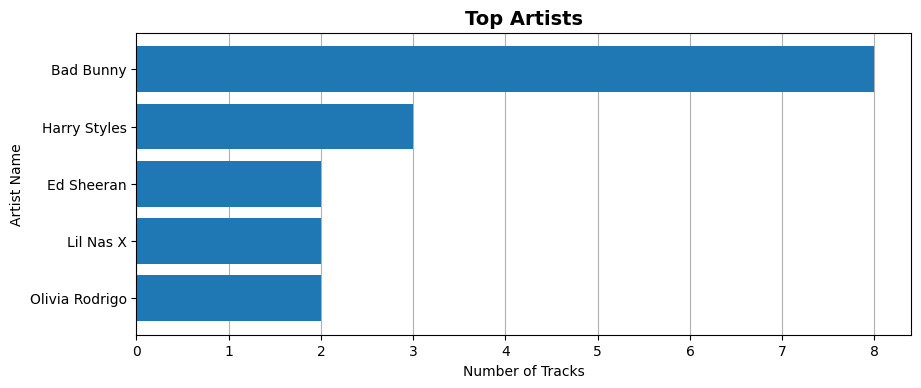

In [13]:
# Group by artist_name and count the number of tracks
top_artists = df.groupby('artist_name')['track_uri'].count().reset_index(name='count')

# Remove artists with a count less than or equal to 1
top_artists = top_artists[top_artists['count'] > 1]

# Sort the artists by count in descending order
top_artists = top_artists.sort_values('count', ascending=False)

# Plot the bar chart
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.barh(top_artists['artist_name'], top_artists['count'], zorder=2)

# Reverse the axis so that the artist names are displayed vertically
ax.invert_yaxis()

# Set the labels and title
ax.set_xlabel("Number of Tracks")
ax.set_ylabel("Artist Name")
ax.set_title("Top Artists")

# Remove the legend and increase the size and boldness of the title
ax.title.set_size(14)
ax.title.set_weight('bold')

# Set the grid lines behind the bars
ax.grid(axis='x', zorder=0)

plt.show()

**Conclusion:** Bad Bunny and Harry Styles e were the top artists of 2017

### Danceability 
Describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.

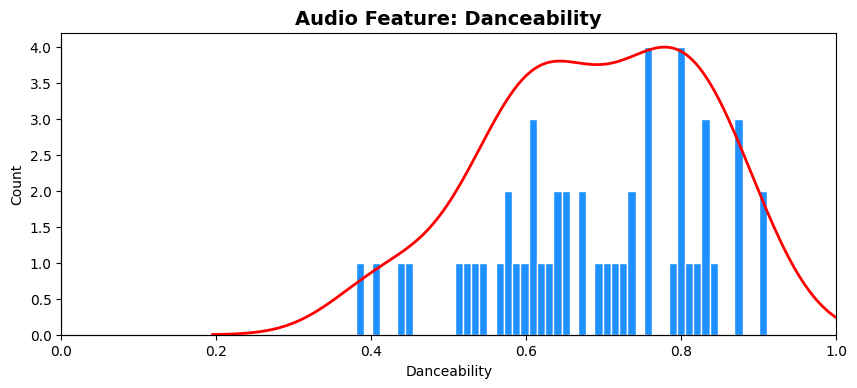

Maximum value of danceability : 0.91
Minimum value of danceability : 0.38
Mean value of danceability:  0.69
The variance of danceability : 0.02
the Standard deviation value of danceability:  0.13


In [14]:
# Extract danceability column from top2017 dataframe
danceability = df['danceability']

# Plot the histogram
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.hist(danceability, bins=50, color='dodgerblue', edgecolor='white')

# Plot the density curve
ax2 = ax.twinx()
sns.kdeplot(danceability, color='red', linewidth=2, ax=ax2)

# Set the labels and title
ax.set_xlabel("Danceability")
ax.set_ylabel("Count")
ax.set_title("Audio Feature: Danceability")
ax.title.set_size(14)
ax.title.set_weight('bold')

# Remove the spines of the density curve
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_visible(False)

# Set axes limits
ax.set_xlim([0, 1])

plt.show();
print("Maximum value of danceability :", round(danceability.max(), 2))
print("Minimum value of danceability :", round(danceability.min(), 2))
print("Mean value of danceability: ", round(danceability.mean(), 2))
print("The variance of danceability :", round(danceability.var(), 2))
print("the Standard deviation value of danceability: ", round(danceability.std(), 2))

### Energy

A measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks 
feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.

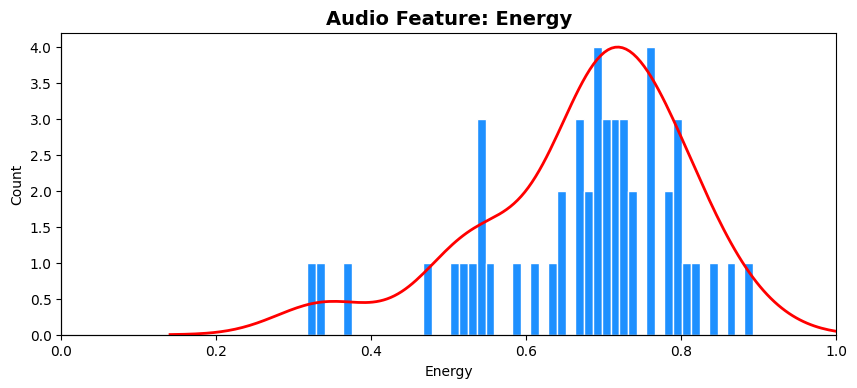

Maximum value of danceability : 0.89
Minimum value of danceability : 0.32
Mean value of danceability:  0.67
The variance of danceability : 0.02
the Standard deviation value of danceability:  0.13


In [15]:
energy = df['energy']

# Plot the histogram
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
ax.hist(energy, bins=50, color='dodgerblue', edgecolor='white')

# Plot the density curve
ax2 = ax.twinx()
sns.kdeplot(energy, color='red', linewidth=2, ax=ax2)

# Set the labels and title
ax.set_xlabel("Energy")
ax.set_ylabel("Count")
ax.set_title("Audio Feature: Energy")
ax.title.set_size(14)
ax.title.set_weight('bold')

# Remove the spines of the density curve
ax2.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.yaxis.set_visible(False)

# Set axes limits
ax.set_xlim([0, 1])
plt.show();
print("Maximum value of danceability :", round(energy.max(), 2))
print("Minimum value of danceability :", round(energy.min(), 2))
print("Mean value of danceability: ", round(energy.mean(), 2))
print("The variance of danceability :", round(energy.var(), 2))
print("the Standard deviation value of danceability: ", round(energy.std(), 2))

### Songs Key Signatures

https://en.wikipedia.org/wiki/Key_signature

In [16]:
df['key_name'] = None

df['key_name'].where(~(df['key'] == 0), "C", inplace=True)
df['key_name'].where(~(df['key'] == 1), "C#", inplace=True)
df['key_name'].where(~(df['key'] == 2), "D", inplace=True)
df['key_name'].where(~(df['key'] == 3), "D#", inplace=True)
df['key_name'].where(~(df['key'] == 4), "E", inplace=True)
df['key_name'].where(~(df['key'] == 5), "F", inplace=True)
df['key_name'].where(~(df['key'] == 6), "F#", inplace=True)
df['key_name'].where(~(df['key'] == 7), "G", inplace=True)
df['key_name'].where(~(df['key'] == 8), "G#", inplace=True)
df['key_name'].where(~(df['key'] == 9), "A", inplace=True)
df['key_name'].where(~(df['key'] == 10), "A#", inplace=True)
df['key_name'].where(~(df['key'] == 11), "B", inplace=True)

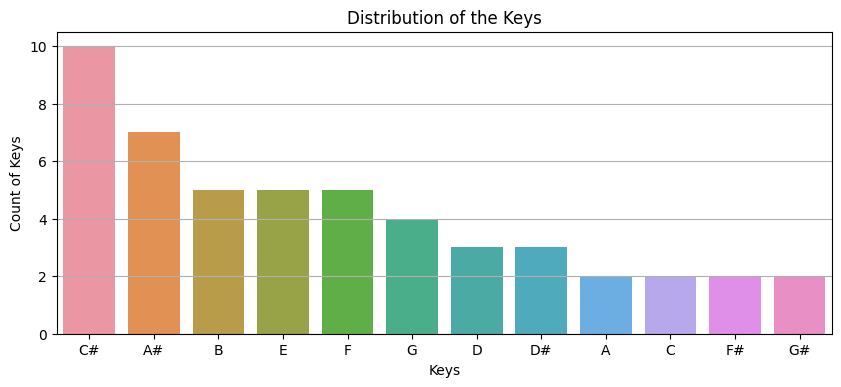

In [17]:
# group by 'key' and calculate the count of each key
song_keys = df.groupby('key_name').size().reset_index(name='n_key')

# sort the keys by count of occurrences
song_keys = song_keys.sort_values('n_key', ascending=False)
song_keys['key_name'] = pd.Categorical(song_keys['key_name'], categories=song_keys['key_name'].tolist()) # sort categorical order

# plot the bar graph
fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
sns.barplot(x='key_name', y='n_key', data=song_keys)
ax.set_title('Distribution of the Keys')
ax.set_xlabel('Keys')
ax.set_ylabel('Count of Keys')
ax.yaxis.grid(True)

plt.show();

**Conclusion:** The most common key among the track was C#

### Loudness
The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.

*Note: I’ve inverted the loudness values from negative to positive*

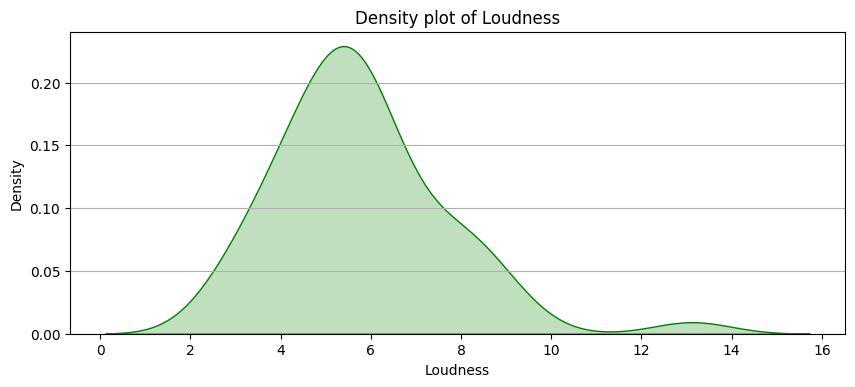

In [22]:
# extraire la variable loudness
loudness = df['loudness'] * -1

fig, ax = plt.subplots(figsize=(10, 4), dpi=100)
sns.kdeplot(loudness, shade=True, color='green')

ax.set_title('Density plot of Loudness')
ax.set_xlabel('Loudness')
ax.set_ylabel('Density')
ax.yaxis.grid(True)

plt.show();